In [1]:
## load packages 
import pandas as pd
import re
import numpy as np

## nltk imports
#!pip install nltk # can install on terminal or by uncommenting this line
#import nltk; nltk.download('punkt'); nltk.download('stopwords')
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import matplotlib.pyplot as plt

## sklearn imports
from sklearn.feature_extraction.text import CountVectorizer

## lda
#!pip install gensim # can install by uncommenting this line
from gensim import corpora
import gensim

## sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

## visualizing LDA--likely need to install
#!pip install pyLDAvis # can install by uncommenting this line
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
pyLDAvis.enable_notebook()

## print mult things
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## random
import random
import string; punctlist = [char for char in string.punctuation] # list of english punctuation marks

In [2]:
import spacy
sp = spacy.load('en_core_web_sm')
import en_core_web_sm
nlp = en_core_web_sm.load()
import ast
import networkx as nx
import urllib, json
from itertools import combinations
from collections import Counter
from netwulf import visualize

In [3]:
data_path = '../../../data/'
output_path = '../../../output/sentiment_analysis/'

In [25]:
all_df = pd.read_csv(f"{data_path}/all_brands_cleaned.csv")
all_df

/var/folders/j0/hl_vhf4s5yd2k4y2b4txq0_m0000gn/T/ipykernel_99332/3841545606.py:1: DtypeWarning: Columns (3,4,17) have mixed types. Specify dtype option on import or set low_memory=False.
  all_df = pd.read_csv(f"{data_path}/all_brands_cleaned.csv")


,content_type,creation_time,hashtags,id,is_branded_content,lang,match_type,mcl_url,modified_time,multimedia,...,post_owner.name,post_owner.username,statistics.comment_count,statistics.like_count,statistics.views,statistics.views_date_last_refreshed,text,brand,text_clean,text_clean_str
0,albums,2025-05-29T13:40:32+00:00,NaN,9037049469730638.0,False,en,"[""post_text""]",https://www.facebook.com/transparency-tools/co...,2025-05-29T14:09:23+00:00,"[{""id"":""1195280392333492"",""type"":""photo"",""url""...",...,NykaaLuxe,nykaaluxe,0.0,5.0,NaN,NaN,Every makeup look starts with the right founda...,Estée Lauder,"['everi', 'start', 'right', 'foundat', 'readi'...",everi start right foundat readi find swipe dis...
1,videos,2025-05-29T11:00:00+00:00,"[""esteelauder"",""esteelauderph""]",677638275152084.0,False,en,"[""post_text""]",https://www.facebook.com/transparency-tools/co...,2025-05-29T11:42:48+00:00,"[{""id"":""677638275152084"",""type"":""video"",""durat...",...,Estée Lauder Philippines Market,esteelauderph,0.0,9.0,258.0,2025-05-29,"Rose-tinted beauty, made to flatter every look...",Estée Lauder,"['rosetint', 'made', 'flatter', 'everi', 'whet...",rosetint made flatter everi whether your go su...
2,videos,2025-05-29T10:11:30+00:00,NaN,664046526456955.0,False,en,"[""post_text""]",https://www.facebook.com/transparency-tools/co...,2025-05-29T11:16:00+00:00,"[{""id"":""664046526456955"",""type"":""video"",""durat...",...,ION Orchard,ion_orchard,0.0,6.0,558.0,2025-05-29,A Day Like No Other is coming on 6 June! Enjoy...,Estée Lauder,"['day', 'june', 'enjoy', 'special', 'partner',...",day june enjoy special partner rebat boost par...
3,albums,2025-05-28T13:00:25+00:00,"[""palmbeach"",""modernluxuryinteriors"",""modernlu...",2187097268387284.0,False,en,"[""post_text""]",https://www.facebook.com/transparency-tools/co...,2025-05-28T13:11:41+00:00,"[{""id"":""1215820702879124"",""type"":""photo"",""url""...",...,Modern Luxury,modernluxury,66.0,3217.0,58152.0,2025-05-29,Aerin Lauder cultivates an elegant legacy in f...,Estée Lauder,"['aerin', 'cultiv', 'eleg', 'legaci', 'full', ...",aerin cultiv eleg legaci full bloom freshli re...
4,videos,2025-05-28T11:00:00+00:00,"[""est\u00e9eessentials"",""esteelauder"",""esteela...",1230348168650378.0,False,en,"[""post_text""]",https://www.facebook.com/transparency-tools/co...,2025-05-29T00:10:07+00:00,"[{""id"":""1230348168650378"",""type"":""video"",""dura...",...,Estée Lauder Philippines Market,esteelauderph,1.0,17.0,828.0,2025-05-29,Beauty that moves with ease — through coffee r...,Estée Lauder,"['move', 'eas', 'coffe', 'run', 'quiet', 'mome...",move eas coffe run quiet moment everyth effort...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217040,photos,2019-05-29T12:45:29+00:00,"[""purpsicle\ud83d\udc9c"",""makdupaddicts"",""inst...",683329014423261.0,False,en,"[""post_text""]",https://www.facebook.com/transparency-tools/co...,2024-04-30T14:53:18+00:00,"[{""id"":""683329014423261"",""type"":""photo"",""url"":...",...,mcneilsbeauty||skincare||makeup||fragrance,mcneilsbeauty,57.0,889.0,NaN,NaN,⚫LIPS • PREP\n\nFENTY BEAUTY \n1. Lip loving s...,Fenty Beauty,"['lip', 'prep', 'lip', 'love', 'scrubstick', '...",lip prep lip love scrubstick gentl lip exfoli ...
217041,photos,2019-05-29T03:39:02+00:00,"[""undertheradar_makeup"",""makeupartist"",""minimu...",683025714510237.0,False,en,"[""post_text""]",https://www.facebook.com/transparency-tools/co...,2024-05-03T09:15:55+00:00,"[{""id"":""683025714510237"",""type"":""photo"",""url"":...",...,Nina Ward,nina.mua,17.0,412.0,NaN,NaN,🍡🍡PINK POPSICLE🍡🍡 Tried out these new fenty be...,Fenty Beauty,"['pink', 'popsicl', 'tri', 'liner', 'day', 'pl...",pink popsicl tri liner day plu cute littl pops...
217042,photos,2019-05-29T02:16:03+00:00,"[""nofilter"",""makeupartist"",""makeupforever"",""fo...",2432526080474570.0,False,en,"[""post_text""]",https://www.facebook.com/transparency-tools/co...,2024-05-02T14:16:13+00:00,"[{""id"

In [6]:
## process text more, lower and to string
# all_df["text_clean_str"] = all_df["text_clean"].apply(lambda tokens: " ".join(tokens).lower() if isinstance(tokens, (list, tuple)) else "")

## Sentiment Analysis

In [7]:
## initialize a scorer
sent_obj = SentimentIntensityAnalyzer()
print(type(sent_obj))
## score one listing
practice_listing = "NICE AND COZY LITTLE APT AVAILABLE"
sentiment_example = sent_obj.polarity_scores(practice_listing)
sentiment_example

<class 'vaderSentiment.vaderSentiment.SentimentIntensityAnalyzer'>


{'neg': 0.0, 'neu': 0.641, 'pos': 0.359, 'compound': 0.4215}

In [8]:
all_df["sentiment"] = all_df["text_clean_str"].astype(str).apply(sent_obj.polarity_scores)

In [9]:
all_df["compound"] = all_df["sentiment"].apply(lambda x: x["compound"])

<Axes: xlabel='statistics.views', ylabel='compound'>

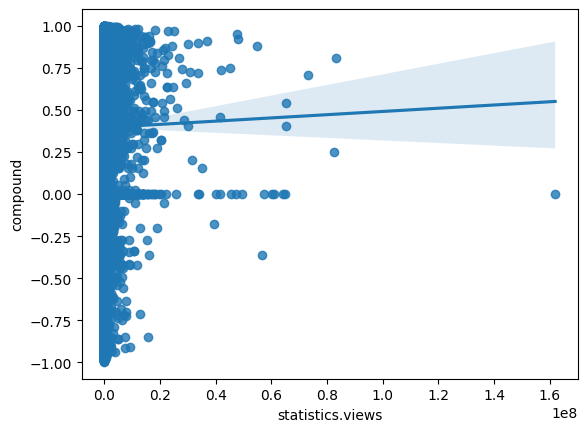

In [10]:
import seaborn as sns
sns.regplot(x = all_df["statistics.views"], y = all_df.compound)
plt.savefig(output_path + "sentiment_vs_views.png", dpi=300, bbox_inches='tight')

<Figure size 1200x600 with 0 Axes>

/var/folders/j0/hl_vhf4s5yd2k4y2b4txq0_m0000gn/T/ipykernel_99332/712586809.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=all_df, x="brand", y="compound", palette="Set2")


<Axes: xlabel='brand', ylabel='compound'>

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Estée Lauder'),
  Text(1, 0, 'Tarte'),
  Text(2, 0, 'Innisfree'),
  Text(3, 0, 'e.l.f'),
  Text(4, 0, 'Glossier'),
  Text(5, 0, 'Laneige'),
  Text(6, 0, 'Sulwhasoo'),
  Text(7, 0, 'Etude'),
  Text(8, 0, 'COSRX'),
  Text(9, 0, 'Fenty Beauty')])

Text(0.5, 1.0, 'Sentiment Distribution per Brand')

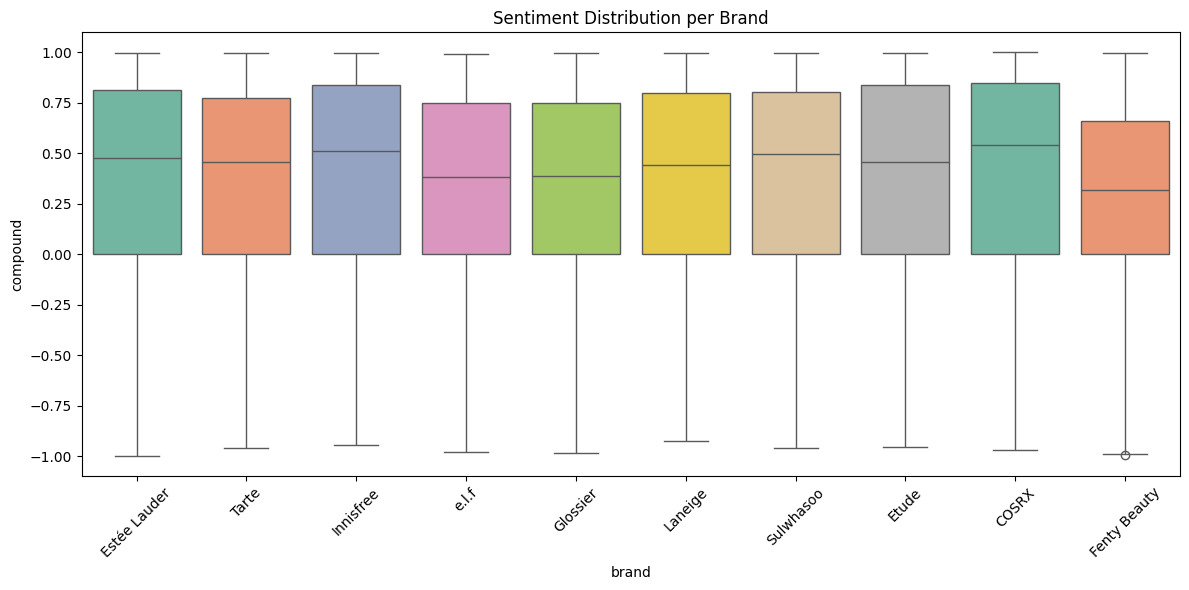

<Figure size 640x480 with 0 Axes>

In [11]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=all_df, x="brand", y="compound", palette="Set2")
plt.xticks(rotation=45)
plt.title("Sentiment Distribution per Brand")
plt.tight_layout()
plt.show()
plt.savefig("sentiment_distribution_per_brand.png", dpi=300, bbox_inches='tight')
plt.savefig(output_path + "sentiment_distribution_per_brand.png", dpi=300, bbox_inches='tight')

<Axes: ylabel='brand'>

Text(0.5, 1.0, 'Average Sentiment Score by Brand')

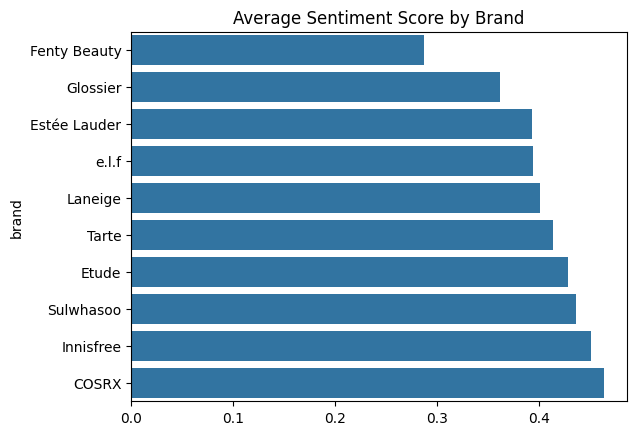

In [12]:
avg_sentiment = all_df.groupby("brand")["compound"].mean().sort_values()
sns.barplot(x=avg_sentiment.values, y=avg_sentiment.index)
plt.title("Average Sentiment Score by Brand")
plt.savefig(output_path + "average_sentiment_by_brand.png", dpi=300, bbox_inches='tight')

In [13]:
korean_brands = ["Innisfree", "Laneige", "Sulwhasoo", "Etude", "COSRX"]
all_df["region"] = all_df["brand"].apply(lambda b: "Korean" if b in korean_brands else "Western")

In [14]:
all_df["engagement_rate"] = all_df["statistics.like_count"] / (all_df["statistics.views"] + 1)
all_df["log_engagement"] = np.log1p(all_df["engagement_rate"])

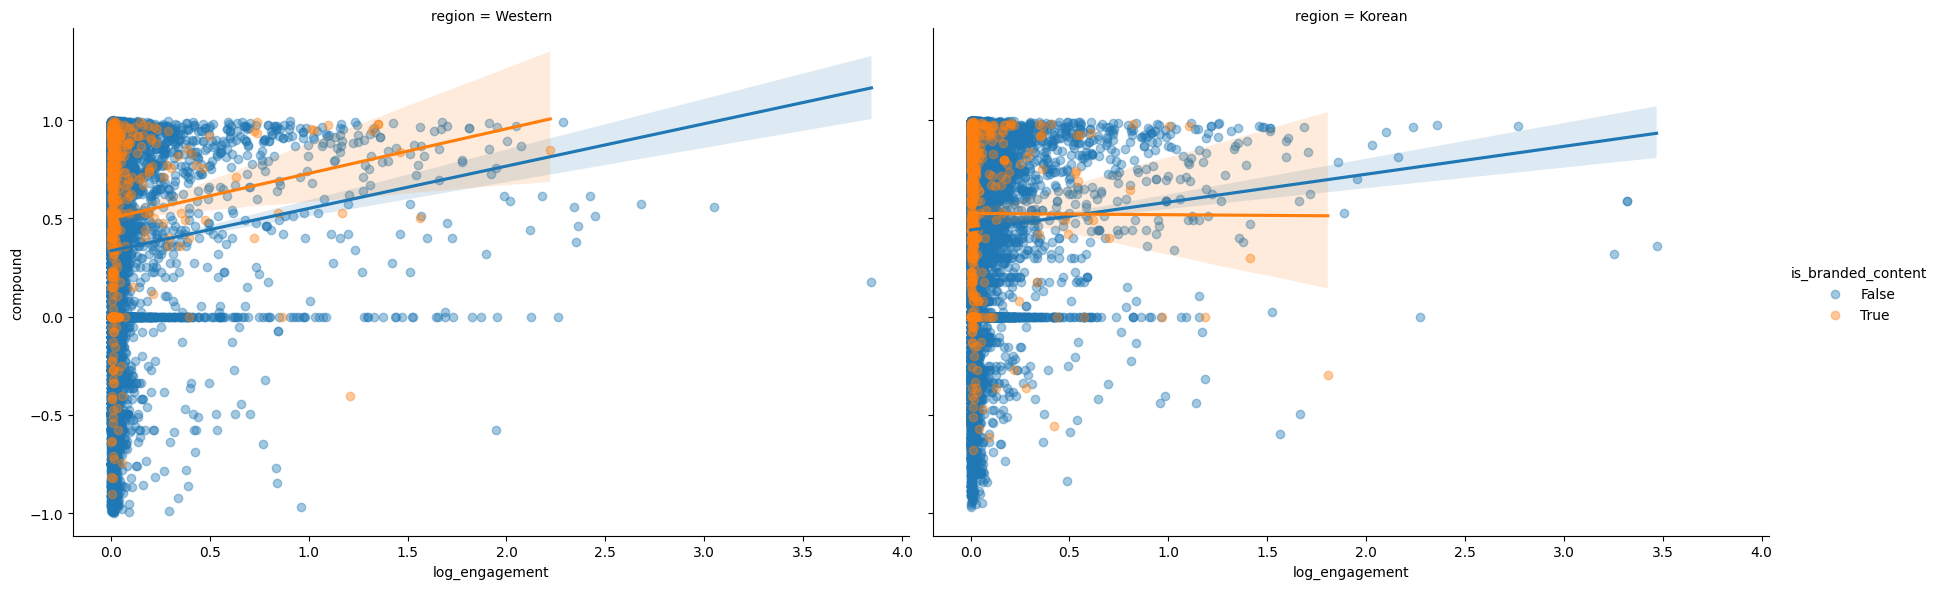

In [15]:
sns.lmplot(
    data=all_df,
    x="log_engagement",
    y="compound",
    hue="is_branded_content",
    col="region",
    scatter_kws={"alpha": 0.4},
    height=6,
    aspect=1.5
)
plt.savefig(output_path + "sentiment_vs_engagement_vs_country.png", dpi=300, bbox_inches='tight')

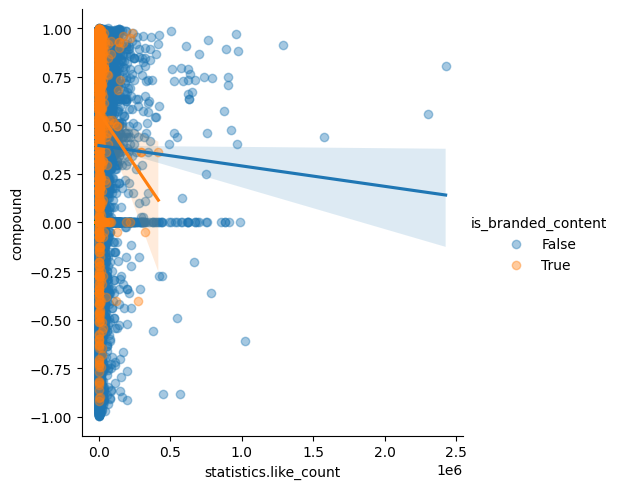

In [16]:
sns.lmplot(data=all_df, x="statistics.like_count", y="compound", hue="is_branded_content", scatter_kws={"alpha": 0.4})
plt.savefig(output_path + "sentiment_vs_like_count.png", dpi=300, bbox_inches='tight')

In [17]:
## convert to list 
all_df['hashtags'] = all_df['hashtags'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith("[") else x
)
hashtag_df = all_df.explode("hashtags")

In [18]:
#normalize hashtag text
hashtag_df["hashtags"] = hashtag_df["hashtags"].astype(str).str.lower().str.strip()
hashtag_df = hashtag_df[hashtag_df["hashtags"].notna() & (hashtag_df["hashtags"] != "")]

In [19]:
# Aggregate sentiment per brand and hashtag
hashtag_sentiment = (
    hashtag_df.groupby(["brand", "hashtags"])
    .agg(avg_sentiment=("compound", "mean"), count=("hashtags", "count"))
    .reset_index()
)

In [20]:
hashtag_stats = (
    hashtag_df.groupby("hashtags")
    .agg(avg_sentiment=("compound", "mean"), count=("compound", "count"))
    .sort_values(by="avg_sentiment", ascending=False)
)

In [21]:
filtered = hashtag_stats[hashtag_stats["count"] >= 50]
filtered.head()

,avg_sentiment,count
hashtags,,
giveawaytime,0.935403,115
giveaways,0.926472,136
giveawaycontest,0.923157,127
skintreatsmaldives,0.919447,66
beatbybarbii,0.916275,162


In [22]:
def compare_branded_hashtags(df, brand_name):
    filtered = df[df["brand"] == brand_name]
    sentiment = (
        filtered.groupby(["hashtags", "is_branded_content"])
        .agg(avg_sentiment=("compound", "mean"), count=("hashtags", "count"))
        .reset_index()
    )
    pivot = sentiment.pivot_table(
        index="hashtags",
        columns="is_branded_content",
        values="avg_sentiment"
    )
    pivot = pivot.rename(columns={
        True: "branded_sentiment", 
        False: "non_branded_sentiment"
    })
    pivot["diff"] = pivot.get("branded_sentiment", 0) - pivot.get("non_branded_sentiment", 0)

    return pivot.dropna().sort_values("diff", ascending=False)


In [23]:
# Ensure output directory exists
# Group by origin, branded status, and hashtag
grouped = (
    hashtag_df.groupby(["origin", "is_branded_content", "hashtags"])
    .agg(avg_sentiment=("compound", "mean"), count=("compound", "count"))
    .reset_index()
)

# Only keep hashtags with sufficient data
grouped = grouped[grouped["count"] >= 5]

# Pivot to compare branded vs. non-branded sentiment per hashtag
origin_comparisons = {}

for origin in ["Korean", "Western"]:
    origin_df = grouped[grouped["origin"] == origin]
    pivot = origin_df.pivot_table(
        index="hashtags",
        columns="is_branded_content",
        values="avg_sentiment"
    )
    pivot = pivot.rename(columns={True: "branded_sentiment", False: "non_branded_sentiment"})
    pivot["diff"] = pivot.get("branded_sentiment", 0) - pivot.get("non_branded_sentiment", 0)
    pivot = pivot.dropna().sort_values("diff", ascending=False)

    print(f"\n{origin} Brands: Top differences in branded vs. non-branded sentiment")
    display(pivot.head(10))

    # Save in case you change your mind
    # safe_name = region.lower()
    # pivot.to_csv(os.path.join(output_dir, f"{safe_name}_branded_vs_nonbranded.csv"), encoding="utf-8")



KeyError: 'origin'

In [ ]:
# Clean hashtags
hashtag_sentiment["hashtags"] = hashtag_sentiment["hashtags"].astype(str)
hashtag_sentiment = hashtag_sentiment[
    hashtag_sentiment["hashtags"].apply(lambda x: all(char in string.printable for char in x))
]

# Define list of brands
brands = hashtag_sentiment["brand"].dropna().unique()

# Top/bottom sentiment charts (from hashtag_sentiment)
for brand in brands:
    filtered = hashtag_sentiment[hashtag_sentiment["brand"] == brand]
    filtered = filtered[filtered["count"] >= 10].sort_values("avg_sentiment", ascending=False)

    if len(filtered) < 10:
        continue

    top10 = filtered.head(10)
    bottom10 = filtered.tail(10)

    # Top 10 Hashtags
    plt.figure(figsize=(16, 9))
    plt.barh(top10["hashtags"], top10["avg_sentiment"], color="green")
    plt.title(f"{brand}: Top 10 Hashtags by Avg Sentiment (min 10 uses)")
    plt.xlabel("Avg Compound Sentiment")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    # Bottom 10 Hashtags
    plt.figure(figsize=(16, 9))
    plt.barh(bottom10["hashtags"], bottom10["avg_sentiment"], color="red")
    plt.title(f"{brand}: Bottom 10 Hashtags by Avg Sentiment (min 10 uses)")
    plt.xlabel("Avg Compound Sentiment")
    plt.gca().invert_yaxis()
    plt.tight_layout()


In [ ]:
# Create output directory if it doesn't exist
output_dir = "../output/hashtag_sentiment_comparison"
os.makedirs(output_dir, exist_ok=True)

for brand in brands:
    brand_df = hashtag_df[hashtag_df["brand"] == brand]

    if brand_df.empty:
        continue

    # Branded content
    branded = brand_df[brand_df["is_branded_content"] == True]
    branded_grouped = (
        branded.groupby("hashtags")
        .agg(avg_sentiment=("compound", "mean"), count=("compound", "count"))
        .query("count >= 5")
        .sort_values("avg_sentiment", ascending=False)
        .head(10)
    )
    branded_grouped["type"] = "Branded"

    # Non-branded content
    nonbranded = brand_df[brand_df["is_branded_content"] == False]
    nonbranded_grouped = (
        nonbranded.groupby("hashtags")
        .agg(avg_sentiment=("compound", "mean"), count=("compound", "count"))
        .query("count >= 5")
        .sort_values("avg_sentiment", ascending=False)
        .head(10)
    )
    nonbranded_grouped["type"] = "Non-Branded"

    # Combine for plotting
    combined = pd.concat([branded_grouped, nonbranded_grouped]).reset_index()

    # Plot and save (horizontal barplot: swap x and y)
    plt.figure(figsize=(14, 8))
    sns.barplot(
        data=combined,
        x="avg_sentiment",
        y="hashtags",
        hue="type",
        palette={"Branded": "green", "Non-Branded": "blue"}
    )
    plt.title(f"{brand}: Top 10 Hashtags by Sentiment (Branded vs Non-Branded)")
    plt.xlabel("Avg Compound Sentiment")
    plt.ylabel("Hashtag")
    plt.tight_layout()

    # Safe filename
    filename = f"{brand.lower().replace(' ', '_')}_top10_sentiment.png"
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()


In [ ]:
# Ensure output directory exists
output_dir = "../output/hashtag_sentiment_comparison"
os.makedirs(output_dir, exist_ok=True)

for brand in brands:
    brand_df = hashtag_df[hashtag_df["brand"] == brand]

    if brand_df.empty:
        continue

    # ── Branded content ──
    branded = brand_df[brand_df["is_branded_content"] == True]
    branded_grouped = (
        branded.groupby("hashtags")
        .agg(avg_sentiment=("compound", "mean"), count=("compound", "count"))
        .query("count >= 5")
    )

    # ── Non-branded content ──
    nonbranded = brand_df[brand_df["is_branded_content"] == False]
    nonbranded_grouped = (
        nonbranded.groupby("hashtags")
        .agg(avg_sentiment=("compound", "mean"), count=("compound", "count"))
        .query("count >= 5")
    )

    # Skip if not enough data
    if branded_grouped.empty or nonbranded_grouped.empty:
        continue

    # ── Bottom 10 sentiment hashtags ──
    branded_bottom = branded_grouped.sort_values("avg_sentiment", ascending=True).head(10)
    branded_bottom["type"] = "Branded"

    nonbranded_bottom = nonbranded_grouped.sort_values("avg_sentiment", ascending=True).head(10)
    nonbranded_bottom["type"] = "Non-Branded"

    bottom_combined = pd.concat([branded_bottom, nonbranded_bottom]).reset_index()

    # ── Order: branded first, then non-branded, both sorted ascending ──
    bottom_combined["type"] = pd.Categorical(bottom_combined["type"], categories=["Branded", "Non-Branded"])
    bottom_combined = bottom_combined.sort_values(by=["type", "avg_sentiment"], ascending=[True, True])

    # Plot
    plt.figure(figsize=(14, 8))
    sns.barplot(
        data=bottom_combined,
        y="hashtags",
        x="avg_sentiment",
        hue="type",
        palette={"Branded": "darkred", "Non-Branded": "gray"}
    )
    plt.title(f"{brand}: Bottom 10 Hashtags by Sentiment (Branded on Top)")
    plt.xlabel("Avg Compound Sentiment")
    plt.ylabel("Hashtag")
    plt.gca().invert_yaxis()
    plt.tight_layout()

    # Save plot
    filename = f"{brand.lower().replace(' ', '_').replace('.', '')}_bottom10_sentiment.png"
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.close()

In [ ]:
pd.set_option('display.max_colwidth', None)     # show full text, not truncated
pd.set_option('display.max_rows', 50)           # increase number of rows shown
pd.set_option('display.max_columns', None)      # if you want to see all columns too

olivia_df = hashtag_df[hashtag_df["hashtags"].str.contains("olivia|rodrigo|brutal|driverslicense", na=False)]
neg_olivia_df = olivia_df[olivia_df["compound"] < 0][["text", "compound"]]
neg_olivia_df

In [ ]:
pd.set_option('display.max_colwidth', None)     # show full text, not truncated
pd.set_option('display.max_rows', 50)           # increase number of rows shown
pd.set_option('display.max_columns', None)      # if you want to see all columns too

lisa_df = hashtag_df[hashtag_df["hashtags"].str.contains("lalisa|jennie", na=False)]
neg_lisa_df = lisa_df[lisa_df["compound"] < 0][["text", "compound"]]
neg_lisa_df